# Vectorized Backtest

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import datetime
from pathlib import Path
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import spearmanr

In [3]:
sns.set_style("whitegrid")
np.random.seed(42)

# settings iniciales

In [4]:
# periodo target. 1 implica que queremos predecir 1 periodo siguiente. (una semana en caso de datos semanales)
periodo_target = 1

## Load Data

### Return Predictions

In [5]:
# DATA_DIR = Path('..', '/12_gradient_boosting_machines/')

In [6]:
# DATA_DIR

In [7]:
# data = pd.read_hdf('00_data/backtest.h5', 'data')
# data.info()

In [8]:
# Lee el archivo hdf
# store = pd.HDFStore('../12_gradient_boosting_machines/../data/predictions.h5')
store = pd.HDFStore("../data/predictions.h5")

# Obtiene las claves
keys = store.keys()

# Cierra el archivo hdf
store.close()

# Imprime las claves
print(keys)

['/rf/train/01', '/rf/test/01', '/lgb/train/01', '/lgb/test/01']


In [9]:
# tomamos los resultados de las 10 mejores configuraciones de los predictores
predictions = pd.concat(
    [
        pd.read_hdf("../data/predictions.h5", "lgb/train/01"),
        pd.read_hdf("../data/predictions.h5", "lgb/test/01").drop("y_test", axis=1),
    ]
)

# tomamos la media
predictions = (
    predictions.loc[
        ~predictions.index.duplicated()
    ]  # si se duplican indices tomara los del train, ose los primeros
    .iloc[:, :10]
    .mean(1)
    .sort_index()
    .dropna()
    .to_frame("prediction")
)
tickers = (
    predictions.index.get_level_values("ticker").unique().tolist()
)  # modificado ticker por symbol

In [10]:
datos_train = pd.read_hdf("../data/predictions.h5", "lgb/train/01")
datos_test = pd.read_hdf("../data/predictions.h5", "lgb/test/01")

In [11]:
# fin del train
datos_train.sort_index().loc["XLY"].tail(1)

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2018-12-30,0.731118,0.648326,0.680983,0.564832,0.906217,-1.375252,-0.205547,0.032736,0.659511,0.03096


In [12]:
# comienzo del test
datos_test.sort_index().loc["XLY"].head(1)

,y_test,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,,
2020-07-26,0.308252,0.999075,1.070298,0.615016,0.844029,0.801678,0.896466,0.790357,1.348412,0.896466,0.738717


In [13]:
# prueba = (pd.read_hdf('../12_gradient_boosting_machines/data/predictions.h5', 'lgb/train/01')
#                   .append(pd.read_hdf('../12_gradient_boosting_machines/data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)))

In [14]:
# prueba.sort_index().loc['XLY.US'].loc['2015'].tail(4)

In [15]:
datos_test.loc["XLY"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2025-03-02 to 2020-10-11
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_test  252 non-null    float64
 1   0       252 non-null    float64
 2   1       252 non-null    float64
 3   2       252 non-null    float64
 4   3       252 non-null    float64
 5   4       252 non-null    float64
 6   5       252 non-null    float64
 7   6       252 non-null    float64
 8   7       252 non-null    float64
 9   8       252 non-null    float64
 10  9       252 non-null    float64
dtypes: float64(11)
memory usage: 23.6 KB


In [16]:
predictions

prediction
ticker date                  
XLB    2007-01-21   -0.350175
       2007-01-28    0.308611
       2007-02-04   -0.046418
       2007-02-11   -0.149312
       2007-02-18   -0.148637
...                       ...
XLY    2025-04-20    0.346060
       2025-04-27    0.083034
       2025-05-04    0.226942
       2025-05-11    0.055604
       2025-05-18    0.172016

[7884 rows x 1 columns]

In [17]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7884 entries, ('XLB', Timestamp('2007-01-21 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  7884 non-null   float64
dtypes: float64(1)
memory usage: 128.2+ KB


In [18]:
# assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)

predicciones = predictions.unstack("ticker").prediction

In [19]:
# predicciones['2019']

In [20]:
predicciones.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 876 entries, 2007-01-21 to 2025-05-18
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLB     876 non-null    float64
 1   XLE     876 non-null    float64
 2   XLF     876 non-null    float64
 3   XLI     876 non-null    float64
 4   XLK     876 non-null    float64
 5   XLP     876 non-null    float64
 6   XLU     876 non-null    float64
 7   XLV     876 non-null    float64
 8   XLY     876 non-null    float64
dtypes: float64(9)
memory usage: 68.4 KB


### SP500 Benchmark

In [21]:
# sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()

In [22]:
# sp500.info()

## Compute Forward Returns

In [23]:
# tomamos los datos

In [24]:
DATA_STORE = "../data/assets.h5"

In [25]:
idx = pd.IndexSlice

In [26]:
with pd.HDFStore(DATA_STORE) as store:
    data = store["data_raw"].sort_index().loc[idx[:, :"2024"], :]

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11754 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2024-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1w   11754 non-null  float64
 1   return_2w   11754 non-null  float64
 2   return_3w   11754 non-null  float64
 3   return_6w   11754 non-null  float64
 4   return_12w  11754 non-null  float64
 5   return_52w  11754 non-null  float64
dtypes: float64(6)
memory usage: 628.9+ KB


In [28]:
# Localizamos target_1w para las fechas y tickers de predictions
predictions_shortened = predictions.index.get_level_values("date").unique()
predictions_shortened = predictions_shortened[
    predictions_shortened <= data.index.get_level_values("date").max()
]
fwd_returns = data.loc[
    idx[predictions.index.get_level_values("ticker").unique(), predictions_shortened], :
].sort_index(ascending=False)

In [29]:
# # localizamos target_1m para las fechas y tickers de predictions
# fwd_returns = data.loc[
#     idx[
#         predictions.index.get_level_values("ticker").unique(),
#         predictions.index.get_level_values("date").unique(),
#     ],
#     :,
# ].sort_index(ascending=False)

In [30]:
fwd_returns

return_1w  return_2w  return_3w  return_6w  return_12w  \
ticker date                                                                 
XLY    2024-12-29   0.005528  -0.011349  -0.003772   0.012660    0.012555   
       2024-12-22  -0.027942  -0.008390   0.009815   0.010409    0.010961   
       2024-12-15   0.011555   0.029240   0.025901   0.027522    0.015291   
       2024-12-08   0.047234   0.033151   0.029364   0.024943    0.016150   
       2024-12-01   0.019257   0.020544   0.011004   0.018191    0.016797   
...                      ...        ...        ...        ...         ...   
XLB    2007-02-18   0.030328   0.014635   0.014838   0.016317    0.006955   
       2007-02-11  -0.000819   0.007181   0.007676   0.008248    0.007493   
       2007-02-04   0.015244   0.011950   0.013075   0.010084    0.007885   
       2007-01-28   0.008666   0.011992   0.017799   0.003318    0.007668   
       2007-01-21   0.015328   0.022397   0.008820   0.002846    0.006666   

                   return_52w  
ticker date                    
XLY    2024-12-29    0.004991  
       2024-12-22    0.004813  
       2024-12-15    0.005424  
       2024-12-08    0.005863  
       2024-12-01    0.005206  
...                       ...  
XLB    2007-02-18    0.003921  
       2007-02-11    0.003807  
       2007-02-04    0.003711  
       2007-01-28    0.003099  
       2007-01-21    0.003865  

[7704 rows x 6 columns]

In [31]:
# daily_returns = data.open.unstack('ticker').sort_index().pct_change()
# daily_returns.info()

# Definimos period target

In [32]:
# creamos la variable target_{lookahead} mesesm
fwd_returns[f"target_{periodo_target}w"] = data.groupby(level="ticker")[
    f"return_{periodo_target}w"
].shift(-periodo_target)

In [33]:
# se hace la asignación del retorno de un perdio fwd

fwd_returns = fwd_returns[f"target_{periodo_target}w"].unstack("ticker").sort_index()

In [34]:
# eliminamos SPY
# fwd_returns.drop('SPY.US', axis=1, inplace=True)
fwd_returns.head()

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2007-01-21,0.008666,0.004772,-0.003788,-0.011510,-0.001283,-0.004510,0.005548,-0.012692,-0.019692
2007-01-28,0.015244,0.031311,0.015480,0.027833,0.017130,0.011703,0.023448,0.014608,0.022663
2007-02-04,-0.000819,-0.004094,-0.005884,-0.009395,-0.008841,-0.010447,0.025337,-0.005471,-0.006296
2007-02-11,0.030328,-0.006679,0.015873,0.022594,0.015293,0.014706,0.005257,0.005501,0.011151
2007-02-18,0.018298,0.011206,-0.012182,-0.001636,0.003347,-0.003345,0.011245,-0.009790,-0.001253


In [35]:
media = fwd_returns.mean(axis=1).shift(1)
media.name = "mediasec"

## Generate Signals

In [36]:
# predictions = data.predicted.unstack('ticker')
# predictions.info()

In [37]:
# eliminamos SPY si comparamos con benchmark
# predicciones.drop('SPY.US', axis=1, inplace=True)
predicciones

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2007-01-21,-0.350175,-0.088973,-0.247529,-0.446366,-0.555426,-0.390388,-0.268085,-0.561386,-0.404270
2007-01-28,0.308611,0.333101,0.555529,0.221877,0.218405,0.350810,0.269089,0.335322,0.485508
2007-02-04,-0.046418,-0.106114,-0.177856,-0.307022,-0.294843,-0.422125,-0.196364,-0.184387,-0.342428
2007-02-11,-0.149312,-0.308749,-0.214410,-0.274035,-0.419545,-0.383535,-0.414396,-0.464249,-0.323651
2007-02-18,-0.148637,0.142394,0.111738,-0.140738,-0.018075,-0.172472,0.117546,0.146224,0.162674
...,...,...,...,...,...,...,...,...,...
2025-04-20,0.185344,0.052015,0.295850,0.197025,0.166181,-0.338500,0.053274,-0.131315,0.346060
2025-04-27,-0.076100,0.116846,0.051151,-0.102205,-0.134045,-0.174737,-0.069326,-0.027765,0.083034
2025-05-04,0.188789,0.447255,0.212820,0.042606,0.044405,-0.000093,0.082443,0.177661,0.226942


In [38]:
N_LONG = N_SHORT = 4

In [39]:
long_signals = (
    predicciones.where(predicciones > 0).rank(axis=1, ascending=False, method="first")
    < N_LONG
).astype(int)
short_signals = (
    predicciones.where(predicciones < 0).rank(axis=1, method="first") < N_SHORT
).astype(int)

In [118]:
def show_table(df, image_name, title):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

    df.index = df.index.date

    ax.axis("tight")
    ax.axis("off")

    table = ax.table(
        cellText=df.reset_index().values,
        colLabels=df.rename_axis("date").reset_index().columns,
        loc="center",
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)

    for (row, col), cell in table.get_celld().items():
        if col == 0:  # Primera columna (date)
            cell.set_width(0.11)  # Ancho para la primera columna
        else:
            cell.set_width(0.06)  # Ancho para las demás columnas

    ax.set_title(title, fontsize=14, pad=-50)

    plt.savefig(
        f"../images/{image_name}.png", dpi=300, bbox_inches="tight", pad_inches=0.01
    )

    plt.show()

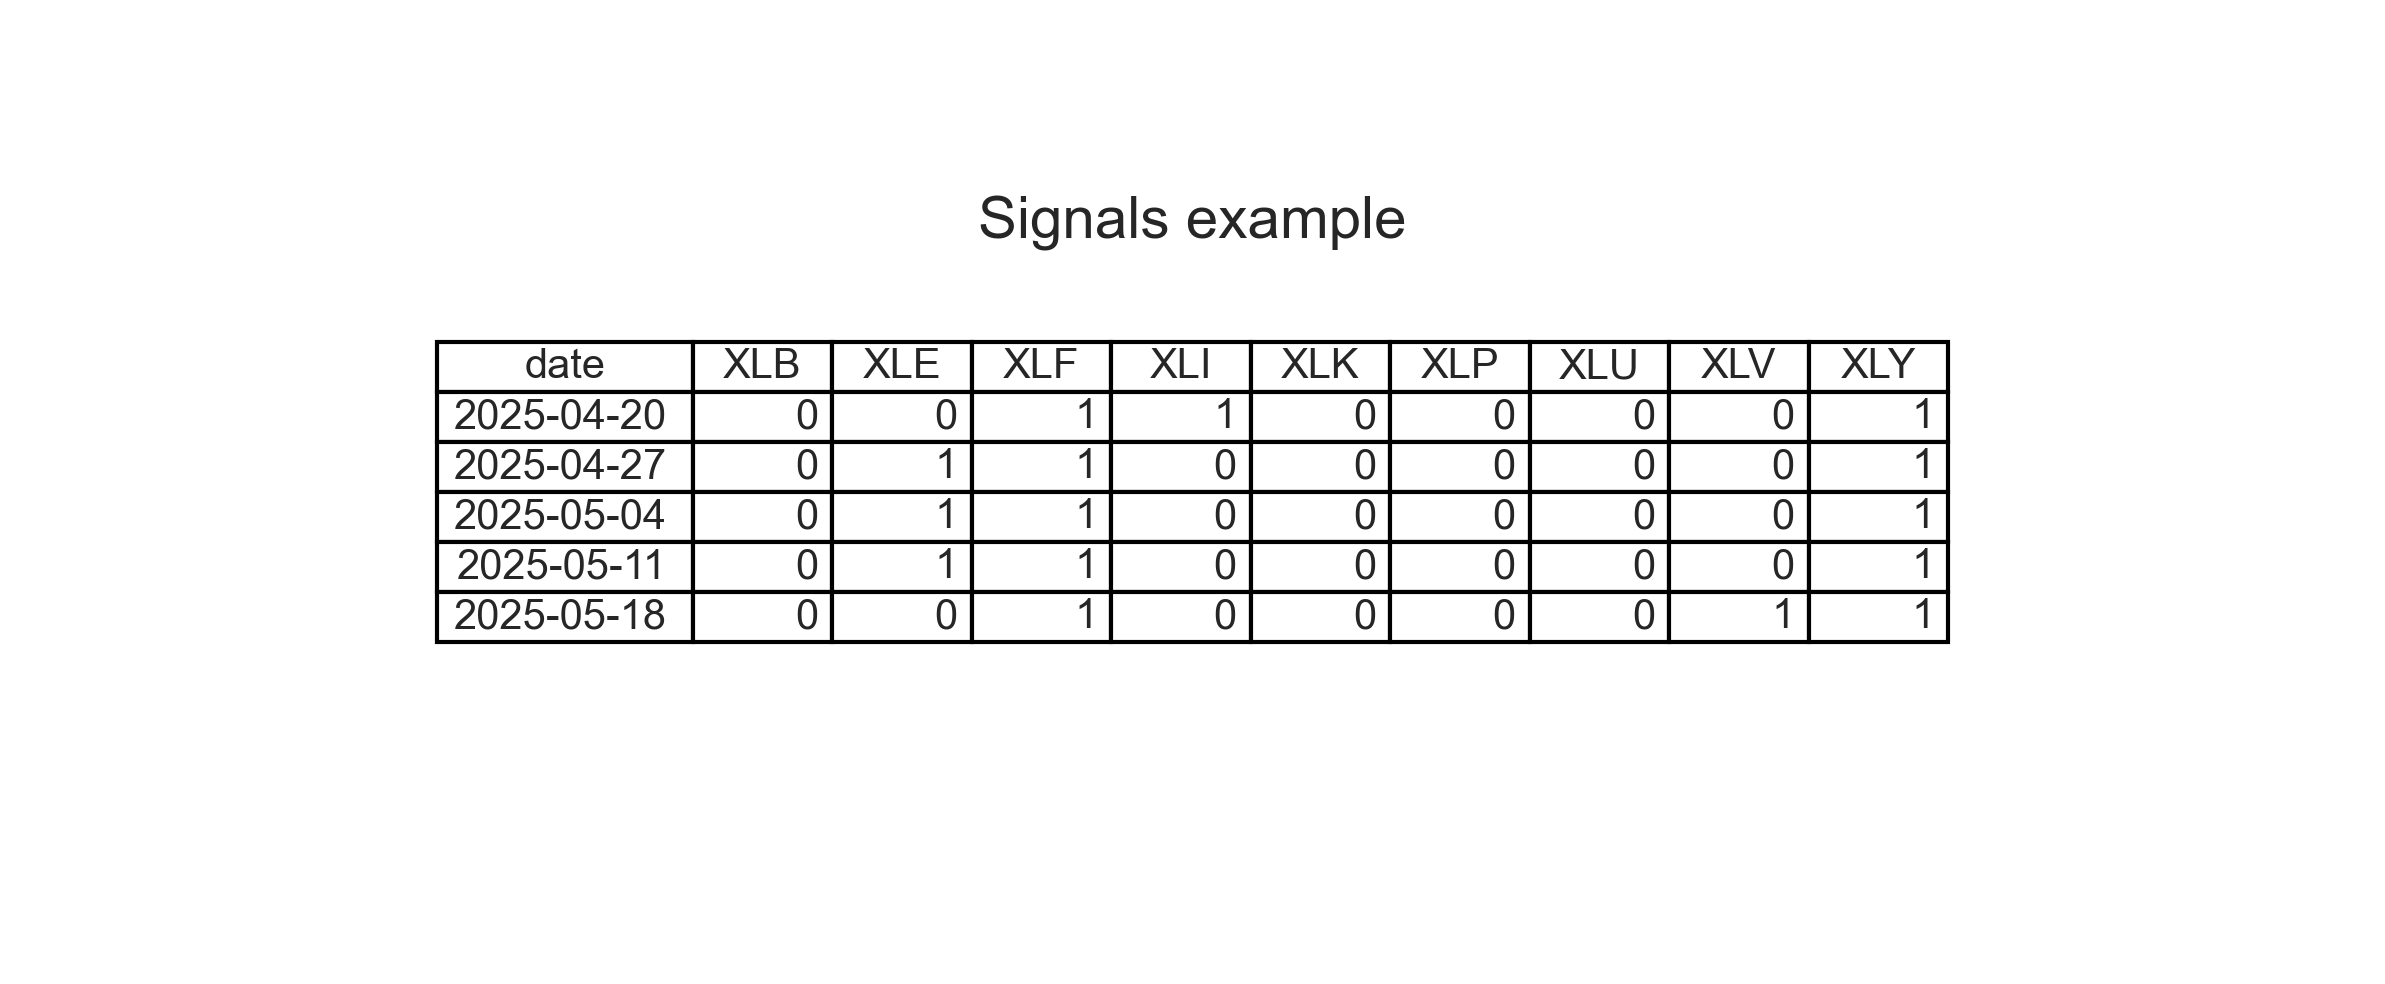

In [121]:
show_table(
    df=long_signals.tail(), image_name="long_signals_table", title="Signals example"
)

## Compute Portfolio Returns

In [40]:
long_returns = long_signals.mul(fwd_returns).replace(0, np.nan).mean(axis=1).fillna(0)
short_returns = (
    short_signals.mul(-fwd_returns).replace(0, np.nan).mean(axis=1).fillna(0)
)
strategy = long_returns.add(short_returns).to_frame("Strategy")

In [124]:
long_returns.head()

date
2007-01-21    0.000000
2007-01-28    0.016615
2007-02-04    0.000000
2007-02-11    0.000000
2007-02-18    0.000055
dtype: float64

In [41]:
short_signals.loc["2019":].describe()

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.134921,0.285714,0.194444,0.146825,0.218254,0.174603,0.182540,0.174603,0.206349
std,0.342319,0.452653,0.396560,0.354636,0.413883,0.380383,0.387057,0.380383,0.405489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
short_returns.head()

date
2007-01-21    0.008495
2007-01-28    0.000000
2007-02-04    0.008713
2007-02-11   -0.008684
2007-02-18   -0.004439
dtype: float64

In [123]:
fwd_returns.head()

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2007-01-21,0.008666,0.004772,-0.003788,-0.011510,-0.001283,-0.004510,0.005548,-0.012692,-0.019692
2007-01-28,0.015244,0.031311,0.015480,0.027833,0.017130,0.011703,0.023448,0.014608,0.022663
2007-02-04,-0.000819,-0.004094,-0.005884,-0.009395,-0.008841,-0.010447,0.025337,-0.005471,-0.006296
2007-02-11,0.030328,-0.006679,0.015873,0.022594,0.015293,0.014706,0.005257,0.005501,0.011151
2007-02-18,0.018298,0.011206,-0.012182,-0.001636,0.003347,-0.003345,0.011245,-0.009790,-0.001253


In [42]:
short_signals.loc["2019":].sum()

ticker
XLB    34
XLE    72
XLF    49
XLI    37
XLK    55
XLP    44
XLU    46
XLV    44
XLY    52
dtype: int64

In [43]:
long_signals.loc["2019":].describe()

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.150794,0.202381,0.250000,0.174603,0.257937,0.277778,0.265873,0.218254,0.285714
std,0.358560,0.402574,0.433874,0.380383,0.438370,0.448795,0.442676,0.413883,0.452653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.250000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
long_signals.loc["2019":].sum()

ticker
XLB    38
XLE    51
XLF    63
XLI    44
XLK    65
XLP    70
XLU    67
XLV    55
XLY    72
dtype: int64

## Plot results

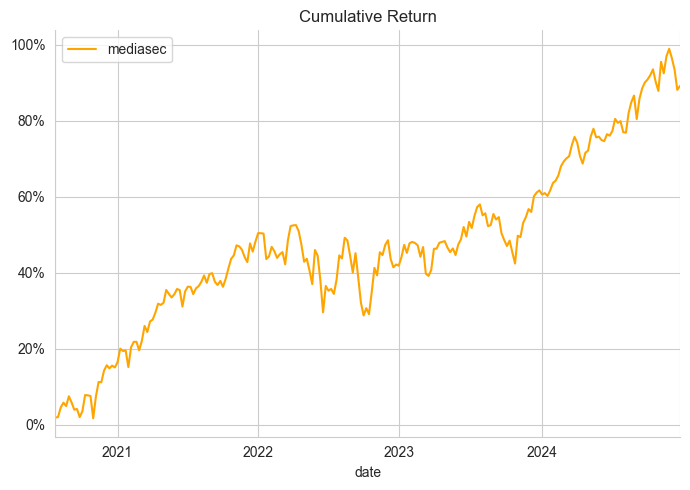

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
media.loc["2019":].add(1).cumprod().sub(1).plot(
    ax=ax, title="Cumulative Return", label="mediasec", color="orange"
)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
ax.legend()
sns.despine()
fig.tight_layout();

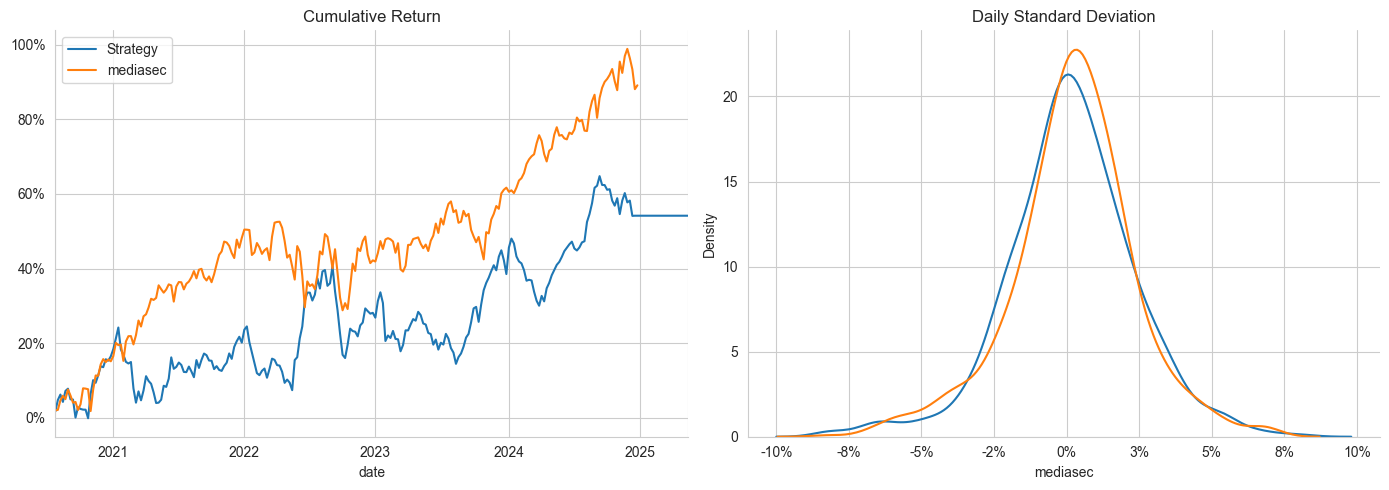

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
strategy.loc["2019":].join(media).add(1).cumprod().sub(1).plot(
    ax=axes[0], title="Cumulative Return"
)
# strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label="Strategy")
sns.distplot(media, ax=axes[1], hist=False, label="media")
axes[1].set_title("Daily Standard Deviation")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
sns.despine()
fig.tight_layout();

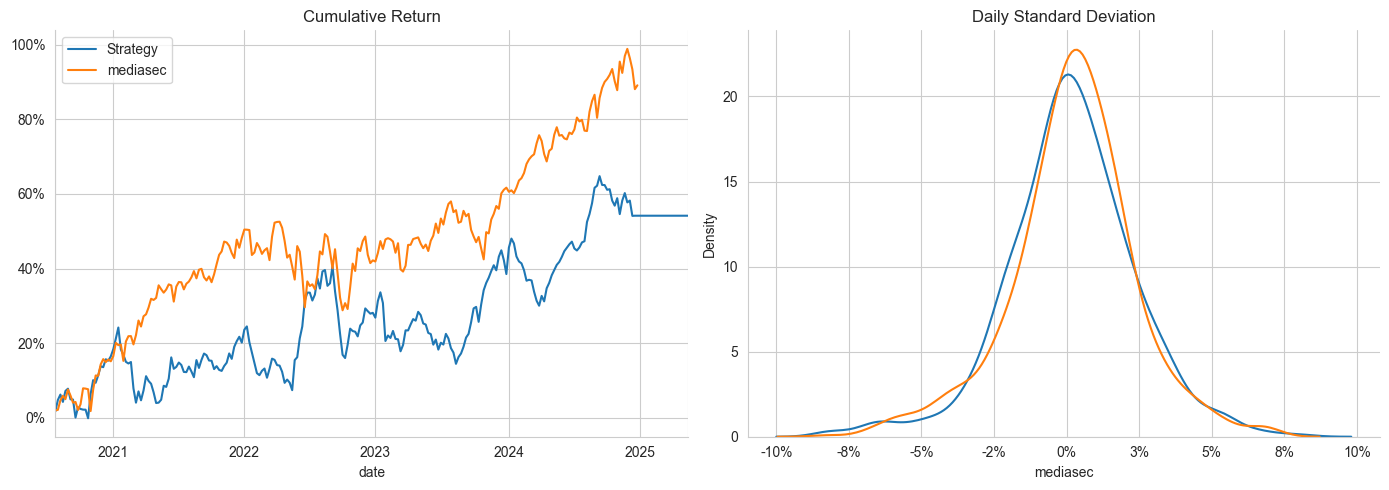

In [55]:
# en vez de s&P, la media
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
strategy.loc["2019":].join(media).add(1).cumprod().sub(1).plot(
    ax=axes[0], title="Cumulative Return"
)
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label="Strategy")
sns.distplot(media, ax=axes[1], hist=False, label="media")
axes[1].set_title("Daily Standard Deviation")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
sns.despine()
fig.tight_layout();

In [56]:
res = strategy.join(media).dropna()

In [57]:
res.std()

Strategy    0.022529
mediasec    0.021613
dtype: float64

<Axes: title={'center': 'Cumulative Forward Returns'}, xlabel='date'>

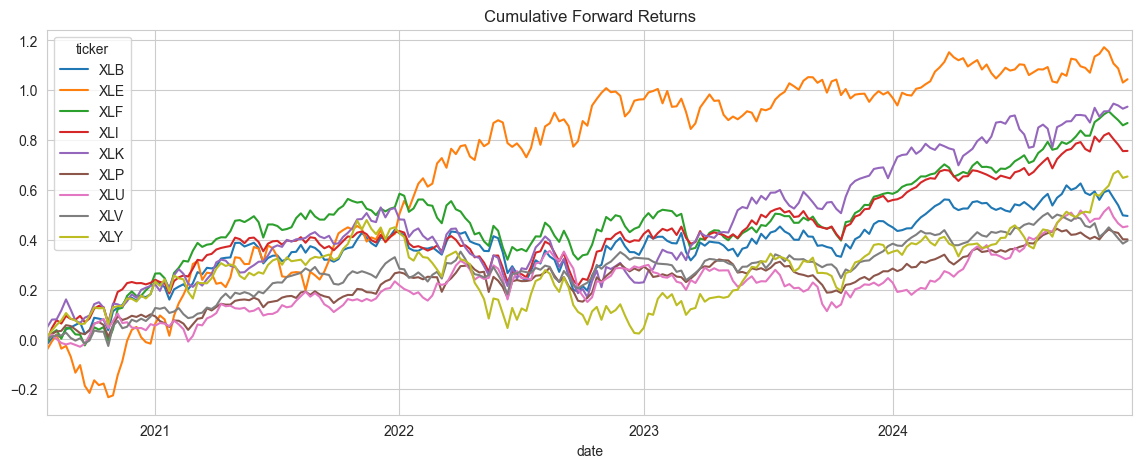

In [47]:
fwd_returns.loc["2019":].cumsum().plot(
    figsize=(14, 5), title="Cumulative Forward Returns"
)

solo largos

In [59]:
# sólo largos
strategy_long = long_returns.to_frame("Strategy")

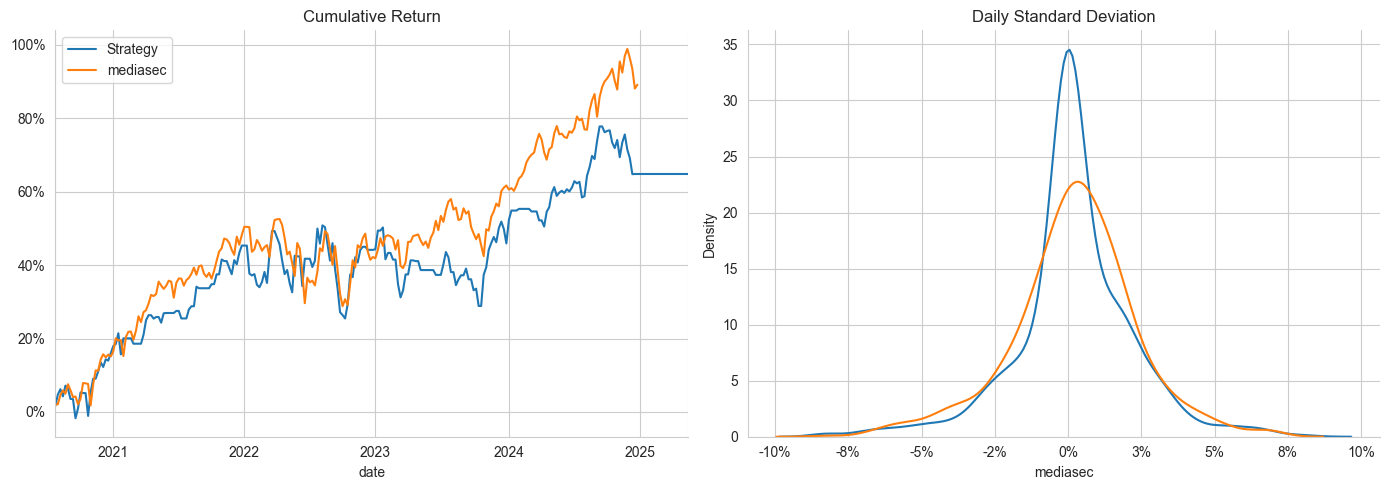

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
strategy_long.loc["2019":].join(media).add(1).cumprod().sub(1).plot(
    ax=axes[0], title="Cumulative Return"
)
sns.distplot(strategy_long.dropna(), ax=axes[1], hist=False, label="Strategy")
sns.distplot(media, ax=axes[1], hist=False, label="media")
axes[1].set_title("Daily Standard Deviation")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
sns.despine()
fig.tight_layout();

solo cortos

In [61]:
# sólo CORTOS
strategy_short = short_returns.to_frame("Strategy")

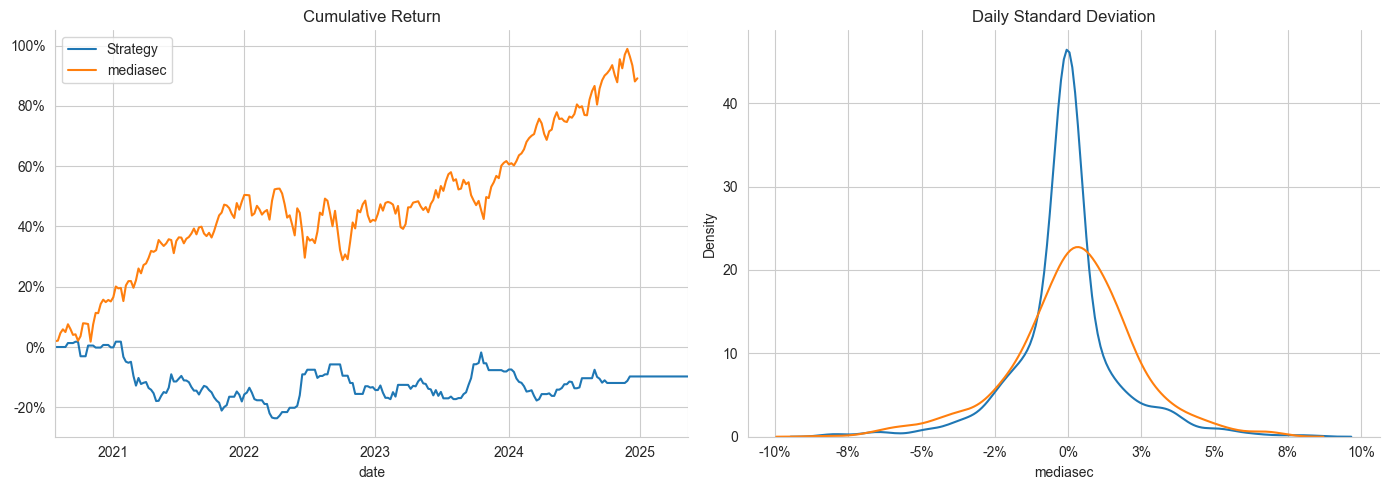

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
strategy_short.loc["2019":].join(media).add(1).cumprod().sub(1).plot(
    ax=axes[0], title="Cumulative Return"
)
sns.distplot(strategy_short.dropna(), ax=axes[1], hist=False, label="Strategy")
sns.distplot(media, ax=axes[1], hist=False, label="media")
axes[1].set_title("Daily Standard Deviation")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
sns.despine()
fig.tight_layout();